# SLAM based on USIP keypoints

Association between keypoints:
* Only between consequtive frames (no loop-closures)
* Based on distance thresholding
* Initial guess for matching is done by A-LOAM odometry prior estimation 

### Data
####  Keypoints
Extracted keypoints from KITTI dataset using USIP: [Google Drive](https://drive.google.com/file/d/1Oa5X4mjT7l_7z8VdunC43UMf8L-gG8pu/view?usp=sharing).

Keypoints per pcd: 64

Non-maximum supprestion distance: 2 meters

#### KITTI

Download odometry GT from [original dataset page](http://www.cvlibs.net/datasets/kitti/eval_odometry.php).

### Imports and main parameters

In [1]:
import open3d as o3d
import numpy as np
import os
import mrob
from scipy import spatial
import collections
import time
from IPython.display import clear_output

In [2]:
# Relative distance thresholding for landmarks association
DIST_THRESHOLD = 0.05

# Number of map in KITTI dataset
MAP = '00'

# Specify here path to downloaded keypoints
KEYPOINTS_PATH = '../../keypoints_kitti_64_2/' + MAP + '/'

# Specify here path to odometry GT for KITTI dataset
KITTI_GT_PATH = '../../data_odometry_poses_USIP/dataset/poses/' + MAP + '.txt'

## Utils

In [3]:
# Returns numpy presentation of point cloud
def get_point_cloud(path, is_keypoint=False):
    pcd_np = None
    if path.endswith('npy'):
        pcd_np = np.load(path)
    elif path.endswith('bin'):
        if is_keypoint:
            pcd_np = np.fromfile(path, dtype=np.float32).reshape(-1, 3)
        else:
            pcd_np = np.fromfile(path, dtype=np.float32).reshape(-1, 4)
    else:
        raise Exception('Point cloud format is not supported')
    
    return pcd_np


# Returns open3d point cloud representation
def get_pcd_from_numpy(np_pcd, color=[0, 0, 1]):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np_pcd)
    pcd.paint_uniform_color(color)
    return pcd

# Transform point cloud using transformation
def transform_array(np_array, T):
    return mrob.geometry.SE3(T).transform_array(np_array)

# Convert quaternion to SE(3) matrix representation
def quat_to_transform(q):
    quat = np.array(q[3:7], dtype='float64')
    T = np.eye(4, dtype='float64')
    T[:3, :3] =  mrob.geometry.quat_to_so3(quat)
    T[0, 3] = q[0]
    T[1, 3] = q[1]
    T[2, 3] = q[2]
    return T

# set1 -- set of keypoints from pcd1
# set2 -- set of keypoints from pcd2
# T - transformation between pcd1 and pcd2
# return -- correspondes between points based on the distance thresholding
def find_correspondences(set1, set2, T):
    corresp = []
    set2_aligned = transform_array(set2, T)
    set2_aligned_tree = spatial.KDTree(set2_aligned)
    picked_flag = np.zeros(set2.shape[0])
    for i in range(set1.shape[0]):
        dist, ind = set2_aligned_tree.query(set1[i], 1)
        if picked_flag[ind] == 0 and dist / np.linalg.norm(set2[ind]) < DIST_THRESHOLD:
            corresp.append((i, ind))
            picked_flag[ind] = 1
    return corresp

## Load GT

In [4]:
import csv

odometry = []
with open(KITTI_GT_PATH, newline='') as csvfile:
    odometry_reader = csv.reader(csvfile, delimiter=' ')
    for row in odometry_reader:
        row = [float(i) for i in row]
        odometry.append(np.array(row).reshape(3, 4))

In [5]:
path_x = []
path_y = []
for matrix in odometry:
    path_x.append(float(matrix[0, 3]))
    path_y.append(float(matrix[2, 3]))

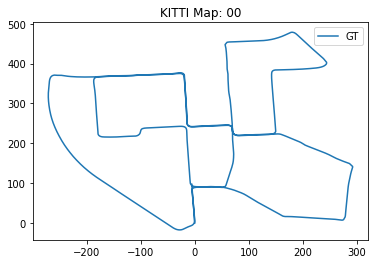

In [6]:
import matplotlib.pyplot as plt

plt.plot(path_x, path_y, label='GT')
plt.title('KITTI Map: ' + MAP)
plt.legend()
plt.show()

## Keypoints extraction

In [7]:
loam_eval_path = '../LOAM_KITTI_eval/' + MAP + '.txt' 

In [8]:
loam_odom_x = []
loam_odom_y = []
loam_odom = []
with open(loam_eval_path, newline='') as csvfile:
    odometry_reader = csv.reader(csvfile, delimiter=',')
    for row in odometry_reader:
        row = [float(i) for i in row]
        loam_odom.append(row)
        loam_odom_x.append(-row[1])
        loam_odom_y.append(row[0])

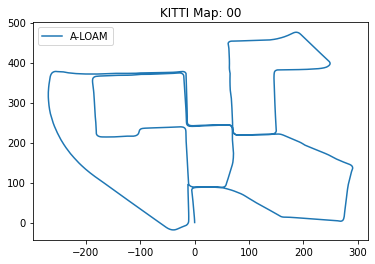

In [9]:
import matplotlib.pyplot as plt

plt.plot(loam_odom_x, loam_odom_y, label='A-LOAM')
plt.title('KITTI Map: ' + MAP)
plt.legend()
plt.show()

## Simple SLAM class

In [10]:
class UsipSLAM:
    def __init__(self, optimization_step=1):
        self.poses_id = []
        self.prev_keypoints = None
        self.graph = mrob.fgraph.FGraph()
        self.last_pos = np.eye(4)
        self.corres_cnt = []
        self.optimization_step = optimization_step

    # delta_T -- transformation from LOAM between consequtive keypoints
    # keypoints -- keypoints associated with considered pcd
    def add_state(self, delta_T, keypoints):
        self.graph.print(True)
        T = self.last_pos @ delta_T
        if not self.poses_id:
            # Add anchor pose
            p = self.graph.add_node_pose_3d(mrob.geometry.SE3(np.eye(4)))
            self.graph.add_factor_1pose_3d(mrob.geometry.SE3(), p, 1e6 * np.eye(6))
            self.poses_id.append(p)
            
            # Remember last keypoints for association on the next step
            self.prev_keypoints = keypoints
        else:
            # Add non-anchor pose
            p = self.graph.add_node_pose_3d(mrob.geometry.SE3(T))
            self.graph.add_factor_2poses_3d(mrob.geometry.SE3(delta_T), p, self.poses_id[-1], np.eye(6))
            self.poses_id.append(p)
            
            corresp = find_correspondences(self.prev_keypoints, keypoints, delta_T)
            self.corres_cnt.append(len(corresp))
            
            # Add factors to corresponding pairs of landmarks
            for pair in corresp:
                l = self.graph.add_node_landmark_3d(np.zeros(3))                
                self.graph.add_factor_1pose_1landmark_3d(keypoints[pair[1]], p, l, np.eye(3))
                self.graph.add_factor_1pose_1landmark_3d(self.prev_keypoints[pair[0]], self.poses_id[-2], 
                                                         l, np.eye(3))
            
            # Remember last keypoints for association on the next step
            self.prev_keypoints = keypoints
            
            
            # Optimize graph if we reached specified number of iterations
            if len(self.poses_id) % self.optimization_step == 0:
                print('Graph optimization')
                self.graph.solve(mrob.fgraph.LM)
            
            # Remember last pose
            self.last_pos = self.graph.get_estimated_state()[self.poses_id[-1]]
    
    def get_poses(self):
        state = self.graph.get_estimated_state()
        return [state[i][:3, 3] for i in self.poses_id]

## Evaluation

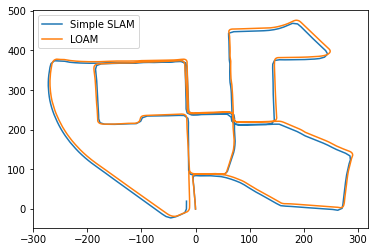

In [22]:
calib_T = np.linalg.inv(np.array([4.276802385584e-04, -9.999672484946e-01, -8.084491683471e-03, -1.198459927713e-02, 
                    -7.210626507497e-03, 8.081198471645e-03, -9.999413164504e-01, -5.403984729748e-02, 
                    9.999738645903e-01, 4.859485810390e-04, -7.206933692422e-03, -2.921968648686e-01,
                   0, 0, 0, 1]).reshape(4, 4))

keypoint_files = os.listdir(KEYPOINTS_PATH)
keypoint_files.sort()
slam = UsipSLAM(optimization_step=150)


start_time = time.time()
times = []

prev_T = np.eye(4)
for i, filename in enumerate(keypoint_files[:-1]):
    idx = filename.split('.')[0]
    keypoints = transform_array(get_point_cloud(KEYPOINTS_PATH + idx + '.bin', is_keypoint=True), calib_T)
    
    T_t = quat_to_transform(loam_odom[int(idx)])
    slam.add_state(np.linalg.inv(prev_T) @ T_t, keypoints)
    times.append(time.time() - start_time)

    prev_T = T_t
    
    if i % 20 == 0:
        poses = slam.get_poses()
        clear_output(True)
        pos_x = []
        pos_y = []
        for i in range(len(poses)):
            pos_x.append(-poses[i][1])
            pos_y.append(poses[i][0])
    
        plt.plot(pos_x, pos_y, label='Simple SLAM')
        plt.plot(loam_odom_x, loam_odom_y, label='LOAM')
        plt.legend()
        plt.show()

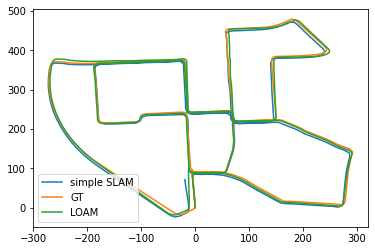

In [23]:
slam.graph.solve(mrob.fgraph.LM)
poses = slam.get_poses()
pos_x = []
pos_y = []
for i in range(len(poses)):
    pos_x.append(-poses[i][1])
    pos_y.append(poses[i][0])
    
plt.plot(pos_x, pos_y, label='simple SLAM')
plt.plot(path_x, path_y, label='GT')
plt.plot(loam_odom_x, loam_odom_y, label='LOAM')
plt.legend()
plt.savefig(MAP + '_res.png')

## Statistics

### Landmark correspondences

In [24]:
import statistics

print('Min num of corresp: {0}'.format(min(slam.corres_cnt)))
print('Max num of corresp: {0}'.format(max(slam.corres_cnt)))
print('Median num of corresp: {0}'
      .format(statistics.median(slam.corres_cnt)))

Min num of corresp: 4
Max num of corresp: 44
Median num of corresp: 29.0


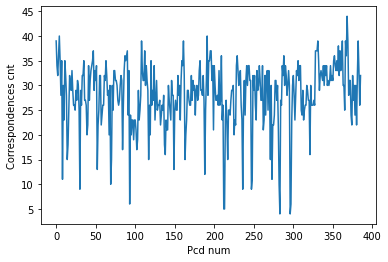

In [25]:
plt.plot(slam.corres_cnt)
plt.xlabel('Pcd num')
plt.ylabel('Correspondences cnt')
plt.show()

### Time performance

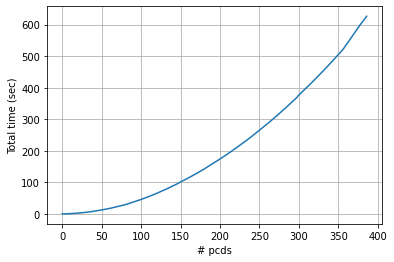

In [27]:
plt.plot(times)
plt.xlabel('# pcds')
plt.ylabel('Total time (sec)')
plt.grid(True)
plt.show()